<a href="https://colab.research.google.com/github/ChintzRuparel/Stock-Market-Prediction-Using-LSTM/blob/main/NIFTYAUTO_HISTORICAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 10.0)

### data set reading

In [4]:
df = pd.read_csv('NIFTY-AUTO.csv') ##Source File to be changed here
df.head()

,Date,Last/Close,Open,High,Low
0,2011-10-03,3534.60,3530.50,3562.60,3512.45
1,2011-10-04,3460.70,3515.60,3537.80,3440.30
2,2011-10-05,3459.35,3473.20,3509.90,3452.85
3,2011-10-07,3535.75,3521.75,3564.20,3513.10
4,2011-10-10,3615.95,3514.80,3622.65,3514.80


### preprocessing data set to perform analysis

In [5]:
df.shape

(2418, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2418 entries, 0 to 2417
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        2418 non-null   object 
 1   Last/Close  2418 non-null   float64
 2   Open        2418 non-null   float64
 3   High        2418 non-null   float64
 4   Low         2418 non-null   float64
dtypes: float64(4), object(1)
memory usage: 94.6+ KB


In [7]:
df1 = df.iloc[:,1]
df1.head()

0    3534.60
1    3460.70
2    3459.35
3    3535.75
4    3615.95
Name: Last/Close, dtype: float64

In [8]:
df1.tail()

2413    10687.70
2414    10685.50
2415    10746.45
2416    10559.70
2417    10552.50
Name: Last/Close, dtype: float64

In [9]:
df1 = df1.replace('[\$,]', '', regex=True).astype(float)
df1.head()

0    3534.60
1    3460.70
2    3459.35
3    3535.75
4    3615.95
Name: Last/Close, dtype: float64

Text(0, 0.5, 'stock price')

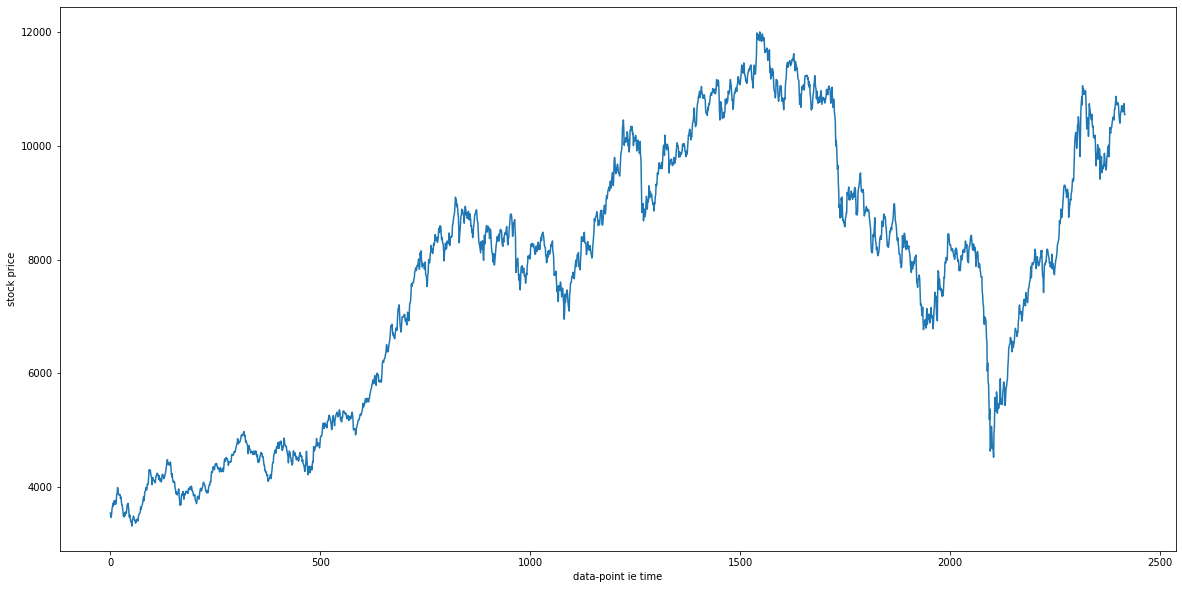

In [10]:
plt.plot(df1)
plt.xlabel("data-point ie time")
plt.ylabel("stock price")

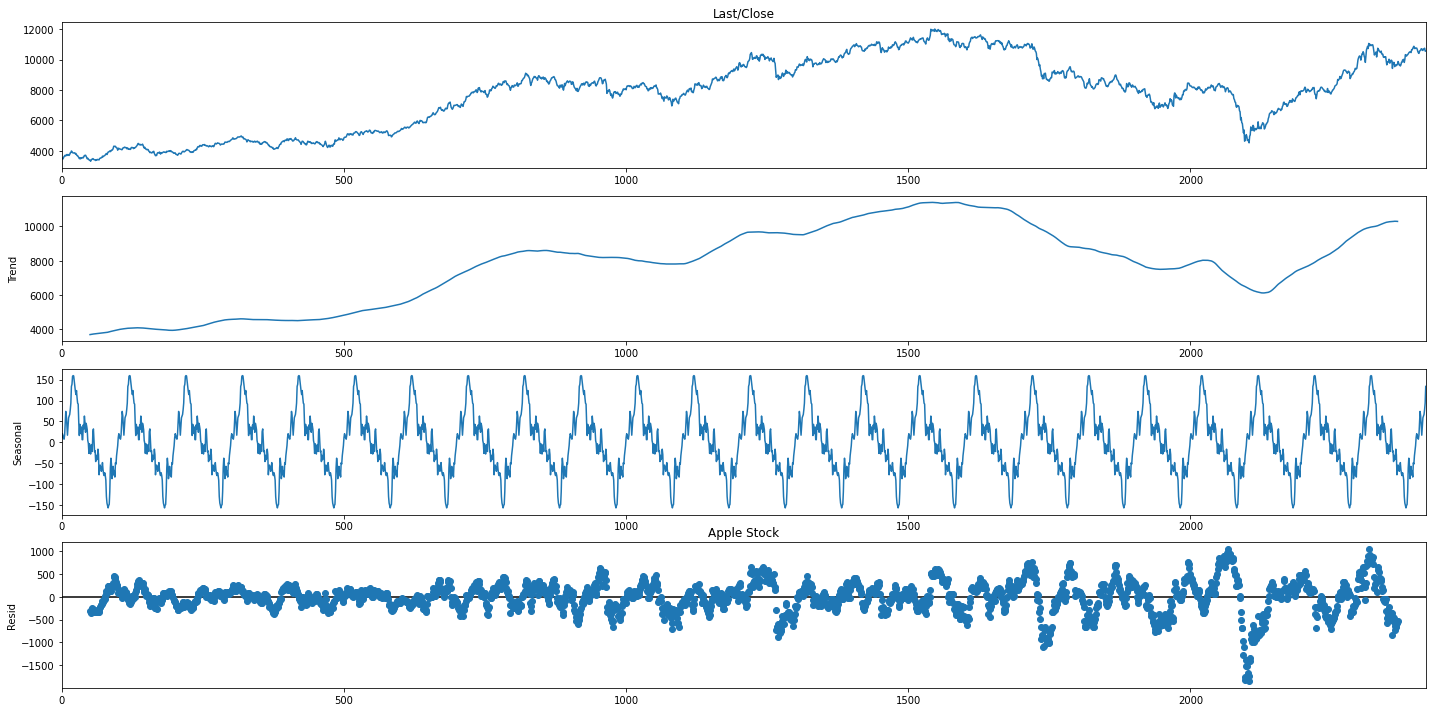

In [11]:
#show the components of this time series
from statsmodels.tsa.seasonal import seasonal_decompose

result  = seasonal_decompose(pd.Series(df1),period=100)

result.plot()
plt.title('Apple Stock')
plt.show()

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

In [13]:
df1.shape

(2418,)

In [14]:
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [15]:
print(df1)
print('\n df1 present shape : ', df1.shape)

[[0.02639892]
 [0.01790945]
 [0.01775437]
 ...
 [0.85488058]
 [0.83342715]
 [0.83260003]]

 df1 present shape :  (2418, 1)


### splitting data (70/30)

In [16]:
training_size = int(len(df1)*0.7)
test_size = len(df1) - training_size
print('Training Size : ',training_size)
print('Test Size : ',test_size)

Training Size :  1692
Test Size :  726


In [17]:
train_data, test_data = df1[0:training_size,:],df1[training_size:len(df1),:]
print('Training Data Shape : ', train_data.shape)
print('Test Data Shape: ', test_data.shape)

Training Data Shape :  (1692, 1)
Test Data Shape:  (726, 1)


### | windowing data set |

In [18]:
def create_dataset(dataset, window=1):
    dataX, dataY= [], []
    for i in range(len(dataset)-window-1):
        a = dataset[i:(i+window),0]
        dataX.append(a)
        dataY.append(dataset[i+window,0])
    return np.array(dataX), np.array(dataY)

In [19]:
window = 100
X_train, y_train = create_dataset(train_data, window=100)
X_test, y_test = create_dataset(test_data, window=100)

In [20]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1591, 100) (1591,)
(625, 100) (625,)


In [21]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

### lstm coding

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [23]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer = 'adam')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


### fitting data to model

In [25]:
model.fit(X_train,y_train,validation_data = (X_test,y_test), epochs = 2, batch_size=64,verbose=1)

Epoch 1/2
25/25 [==============================] - 16s 350ms/step - loss: 0.0523 - val_loss: 0.0140
Epoch 2/2
25/25 [==============================] - 6s 250ms/step - loss: 0.0030 - val_loss: 0.0032


In [26]:
y_pred = scaler.inverse_transform(model.predict(X_test))

20/20 [==============================] - 3s 68ms/step


In [27]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [28]:
y_pred[:5]

array([[9041.565],
       [9053.855],
       [9064.413],
       [9072.955],
       [9077.57 ]], dtype=float32)

In [29]:
y_test[:5]

array([[9223.8 ],
       [9235.55],
       [9182.45],
       [8902.65],
       [8767.35]])

### evaluation

In [30]:
import math
from sklearn.metrics import mean_squared_error

rmse_score = math.sqrt(mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error(test) : ',rmse_score)

Root Mean Squared Error(test) :  495.0107545064629


In [31]:
from sklearn.metrics import r2_score
print('R-squared Score  : ',r2_score(y_test,y_pred))

R-squared Score  :  0.87029446048971


### visualization + plotting

50/50 [==============================] - 3s 52ms/step


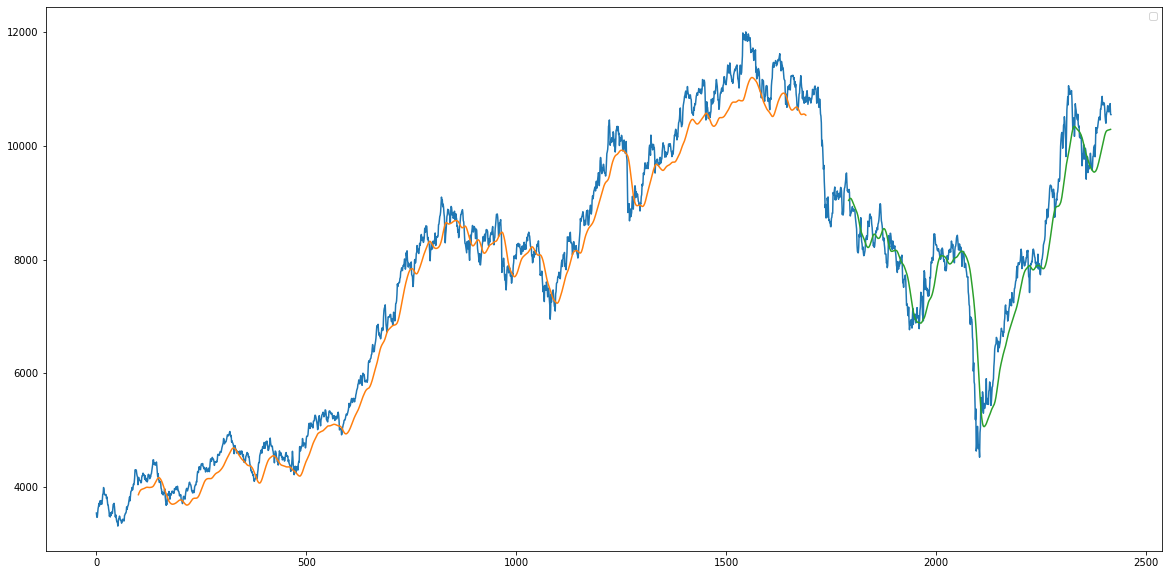

In [32]:
# shift train predictions for plotting
train_predict = scaler.inverse_transform(model.predict(X_train))

look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = y_pred
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend()
plt.show()

### predicting 30 Days future value

In [33]:
x_input=test_data[len(test_data)-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [34]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [35]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

#print(lst_output)

In [36]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [37]:
print(scaler.inverse_transform(lst_output))

[[10297.06397663]
 [10296.15442824]
 [10292.0119101 ]
 [10284.58557467]
 [10274.1519703 ]
 [10261.14848964]
 [10246.06648598]
 [10229.38226588]
 [10211.52388263]
 [10192.85245757]
 [10173.6569915 ]
 [10154.17096805]
 [10134.55990115]
 [10114.96024901]
 [10095.45295261]
 [10076.10338736]
 [10056.94787294]
 [10038.01598393]
 [10019.31757853]
 [10000.86251494]
 [ 9982.64352923]
 [ 9964.66373451]
 [ 9946.91690454]
 [ 9929.39785082]
 [ 9912.1003471 ]
 [ 9895.01972371]
 [ 9878.14664131]
 [ 9861.47850564]
 [ 9845.0064962 ]
 [ 9828.72853758]]


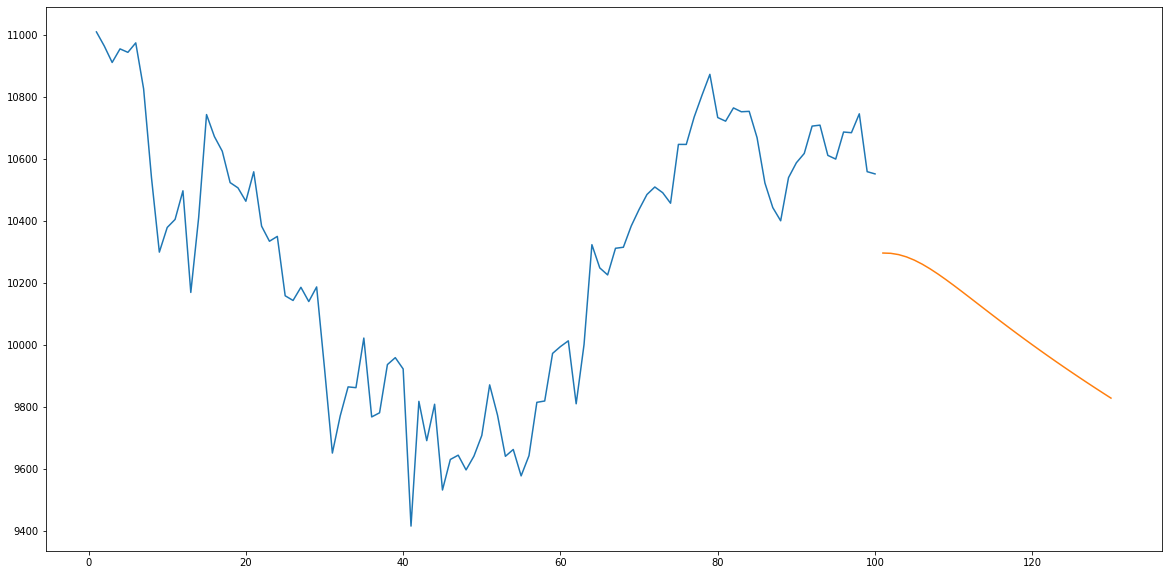

In [38]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))